In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from typing import Optional
import pickle



In [41]:
def get_env(
    env_name: str,
    render_mode="rgb_array",
) -> gym.Env:
    env = gym.make(env_name, render_mode=render_mode)

    return env

### For the FrozenLake Environmnet

The FrozenLake environment has Discrete state and action space

In [42]:
def argmax(a):
    # random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a), dtype=int)[a == np.max(a)])


def Qlearn(
    build_env,
    alpha=0.2,
    gamma=0.99,
    min_epsilon=0.1,
    nsteps=800000,
    Qmat=None,
    callback_freq=5000,
    callback=None,
):
    if Qmat is None:
        Qmat = defaultdict(float)

    episode_reward = 0
    mean_episodic_reward = 0
    n_episodes = 0

    epsilon = 1.0

    env: gym.Env = build_env()
    obs, info = env.reset()

    pbar = tqdm(range(nsteps), colour="green")
    for i in pbar:
        if np.random.rand() < epsilon:
            # Exploration: choose a random action
            action = env.action_space.sample()
        else:
            # Exploitation: choose the action with the highest Q-value
            action = argmax([Qmat[obs, i] for i in range(env.action_space.n)])

        next_obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward

        if not terminated and not truncated:

            Q_next = max(
                Qmat[next_obs, action_next] for action_next in range(env.action_space.n)
            )  # Get the maximum Q-value for the next state

            # Update Q-value using Q-learning update rule
            Qmat[obs, action] += alpha * (reward + gamma * Q_next - Qmat[obs, action])

            obs = next_obs
        else:
            # Episode ends, update mean episodic reward and reset environment
            Qmat[obs, action] += alpha * (reward - Qmat[obs, action])
            n_episodes += 1
            mean_episodic_reward += (episode_reward - mean_episodic_reward) / n_episodes
            episode_reward = 0
            obs, info = env.reset()

        epsilon = max(min_epsilon, 0.999995 * epsilon)

        if i % callback_freq == 0:
            if callback is not None:
                # Execute callback function if provided
                callback(build_env, Qmat)
        pbar.set_description(
            f"Mean episodic reward: {mean_episodic_reward:.2f} | Epsilon: {epsilon:.2f} | Best reward: {best_reward:.2f}"
        )

    return Qbest


def test(build_env, Qmat, test_steps=1000):
    global Qbest, best_reward

    env: gym.Env = build_env()
    n_episodes = 0
    tot_rewards = 0

    obs, info = env.reset()
    for _ in range(test_steps):
        # Choose the action with the highest Q-value
        action = argmax([Qmat[obs, i] for i in range(env.action_space.n)])
        next_obs, reward, terminated, truncated, info = env.step(action)

        tot_rewards += reward
        obs = next_obs

        if terminated or truncated:
            n_episodes += 1
            obs, info = env.reset()

    if best_reward < tot_rewards / n_episodes:
        # Update the best reward and Q-best if a better reward is achieved
        best_reward = tot_rewards / n_episodes
        Qbest = deepcopy(Qmat)

    return tot_rewards / n_episodes

In [ ]:
Qbest = None
best_reward = -np.inf
build_env = lambda: get_env("FrozenLake-v1")

Qbest = Qlearn(build_env, alpha=0.1, callback=test, nsteps=100000)

In [ ]:
env = get_env("FrozenLake-v1", render_mode="human")
obs, info = env.reset()
n_episodes = 3

for i in range(n_episodes):
    terminated = False
    truncated = False
    obs, info = env.reset()
    while not terminated and not truncated:
        action = argmax([Qbest[obs, i] for i in range(env.action_space.n)])
        obs, reward, terminated, truncated, info = env.step(action)

In [ ]:
with open("Qbest_frozenlake.pkl", "wb") as f:
    pickle.dump(Qbest, f)

### For the Pendulum Environment

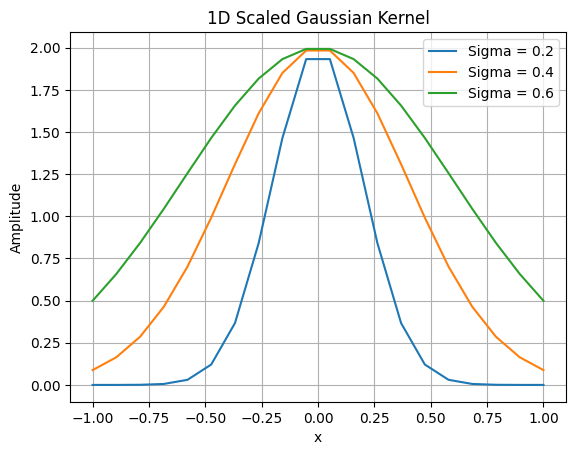

In [3]:
# Define the Gaussian function
def gaussian(x, mu, sigma, max_amp):
    return max_amp * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Generate the x values
x = np.linspace(-1, 1, 20)

# Compute the Gaussian kernel centered at 0 with standard deviation of 1
mu = 0
plt.plot(x, gaussian(x, mu, sigma=0.2, max_amp=2), label='Sigma = 0.2')
plt.plot(x, gaussian(x, mu, sigma=0.4, max_amp=2), label='Sigma = 0.4')
plt.plot(x, gaussian(x, mu, sigma=0.6, max_amp=2), label='Sigma = 0.6')


plt.xlabel('x')
plt.ylabel('Amplitude')
plt.title('1D Scaled Gaussian Kernel')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
class PendulumDiscreteStateAction(gym.Wrapper):
    """
    A wrapper class that discretizes the observation and action spaces of the Pendulum environment.
    """

    def __init__(self, env: gym.Env, nvec_s: list[int], nvec_u: int, sigma: float):
        """
        Initializes the PendulumDiscreteStateAction wrapper.

        Parameters:
        - env: The original Pendulum environment.
        - nvec_s: A list of integers representing the number of discrete values for each dimension of the observation space.
        - nvec_u: A list of integers representing the number of discrete values for each dimension of the action space.
        """
        super(PendulumDiscreteStateAction, self).__init__(env)

        self.env = env
        self.nvec_s = nvec_s
        self.nvec_u = nvec_u

        # Check if the observation space is of type Box
        assert isinstance(
            env.observation_space, gym.spaces.Box
        ), "Error: observation space is not of type Box"

        # Check if the length of nvec_s matches the shape of the observation space
        assert (
            len(nvec_s) == env.observation_space.shape[0]
        ), "Error: nvec_s does not match the shape of the observation space"

        # Create a MultiDiscrete observation space and action space
        self.observation_space = gym.spaces.MultiDiscrete(nvec_s)
        self.action_space = gym.spaces.Discrete(nvec_u)

        # Define the possible actions
        
        kernel = gaussian(np.linspace(0, 1, 5), 0, sigma, 2)
        self.actions = (-kernel).tolist() + [0] + np.flip(kernel).tolist()
        # self.actions = [-2.0, -1.0, -0.5, -0.25, -0.15, 0.0, 0.15, 0.25, 0.5, 1.0, 2.0]

    def _discretize_observation(self, obs: np.ndarray[int | float]) -> np.ndarray[int]:
        """
        Discretizes the continuous observation into a discrete observation.

        Parameters:
        - obs: The continuous observation.

        Returns:
        - The discretized observation.
        """
        # Discretize each dimension of the observation
        for i in range(len(obs)):
            obs[i] = int(
            (obs[i] - self.env.observation_space.low[i])
            / (
                self.env.observation_space.high[i]
                - self.env.observation_space.low[i]
            )
            * self.nvec_s[i]
            ) # equation: (x - min) / (max - min) * nvec
        return obs.astype(int)

    def step(self, action: int) -> tuple[np.ndarray[int], float, bool, dict]:
        """
        Takes a step in the environment.

        Parameters:
        - action: The discrete action.

        Returns:
        - The next discrete observation, reward, termination flag, truncated flag, and additional information.
        """
        action = self.actions[action]
        obs, reward, terminated, truncated, info = self.env.step([action])
        obs = self._discretize_observation(obs)
        return tuple(obs), reward, terminated, truncated, info

    def reset(self) -> tuple[np.ndarray[int], dict]:
        """
        Resets the environment.

        Returns:
        - The initial discrete observation and additional information.
        """
        obs, info = self.env.reset()
        obs = self._discretize_observation(obs)
        return tuple(obs), info

In [46]:
def get_env(
    env_name: str,
    nvec_s: Optional[list[int]] = None,
    nvec_u: int=None,
    time_limit: Optional[int] = None,
    sigma: Optional[float] =  None,
    render_mode="rgb_array",
) -> gym.Env:
    env = gym.make(env_name, render_mode=render_mode)

    if nvec_s is not None and nvec_u is not None:
        env = PendulumDiscreteStateAction(env, nvec_s, nvec_u, sigma=sigma)

    if time_limit is not None:
        env = gym.wrappers.TimeLimit(env, max_episode_steps=time_limit)

    return env

In [47]:
Qbest = None
best_reward = -np.inf

In [ ]:
build_env = lambda: get_env("Pendulum-v1", [10, 10, 10], 11, 200, sigma = 0.5)
Qlearn(build_env, alpha=0.2, callback=test, nsteps=1000000)

In [ ]:
import pickle
with open("Qbest_pendulum.pkl", "wb") as f:
    pickle.dump(Qbest, f)

In [ ]:
# load the Q-best values
with open("models/tabular/Qbest_pendulum.pkl", "rb") as f:
    Qbest = pickle.load(f)

In [ ]:
env = get_env("Pendulum-v1", [10, 10, 10], 11, 200, sigma = 0.5, render_mode="human")
obs, info = env.reset()
n_episodes = 3

for i in range(n_episodes):
    terminated = False
    truncated = False
    obs, info = env.reset()
    while not terminated and not truncated:
        action = argmax([Qbest[obs, i] for i in range(env.action_space.n)])
        obs, reward, terminated, truncated, info = env.step(action)